In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [3]:
hi_maps= np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_hi_maps.npy")
# hi_maps= np.load("/home/urwa/MASS_Thesis/HI/hi_corr_maps.npy")
# noise_maps= np.load("/home/urwa/MASS_Thesis/Thesis/noise_nf.npy")*10
# ff=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_ff_maps.npy")
# sync=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_sync_maps.npy")

# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
# hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")
# noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

# fgds=(ff+sync)/2e8
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)
# cl_noise= compute_covariance(noise_maps, lmax, almsize, nfreqs)
# cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [4]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [5]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
# *_,noise_binned= bin_spectra(cl_noise, 10)
# *_, fgds_binned= bin_spectra(cl_fgds, 10)
# total=hi_maps + noise_maps[:54] +fgds
# cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
# *_, chat_binned= bin_spectra(cl_hat, 10)

In [6]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nbins, nfreqs, nfreqs))
    for l in range (nbins):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag
hi_d= diagonalize_matrices(hi_binned, nfreqs)
#print(hi_d[10])

In [7]:
bins=7

In [8]:
def build_trapezoidal_basis(freqs, bin, top_width=0.5):
    """
    Create trapezoidal basis functions (___/----\___) on frequency grid.
    
    Parameters:
    - freqs: 1D array of frequency bin centers (nf,)
    - n_bins: number of trapezoidal functions (i.e., nq)
    - top_width: fraction of bin width used for the flat top (0 < top_width < 1)

    Returns:
    - phi: shape (n_bins, nf), the basis matrix
    """
    nf = len(freqs)
    vmin, vmax = freqs[0], freqs[-1]
    bin_edges = np.linspace(vmin, vmax, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]
    flat_top = top_width * bin_width
    slope_width = (1 - top_width) * bin_width / 2  #slope= 1/slope_width

    phi = np.zeros((bin, nf))

    for i in range(bin):
        # Define edges of the trapezoid
        left = bin_edges[i] - slope_width
        start_flat = bin_edges[i]
        end_flat = bin_edges[i + 1]
        right = bin_edges[i + 1] + slope_width

        for j, v in enumerate(freqs):
            if left <= v < start_flat:
                phi[i, j] = (v - left) / slope_width
            elif start_flat <= v <= end_flat:
                phi[i, j] = 1.0
            elif end_flat < v <= right:
                phi[i, j] = (right - v) / slope_width
            else:
                phi[i, j] = 0.0

    return phi


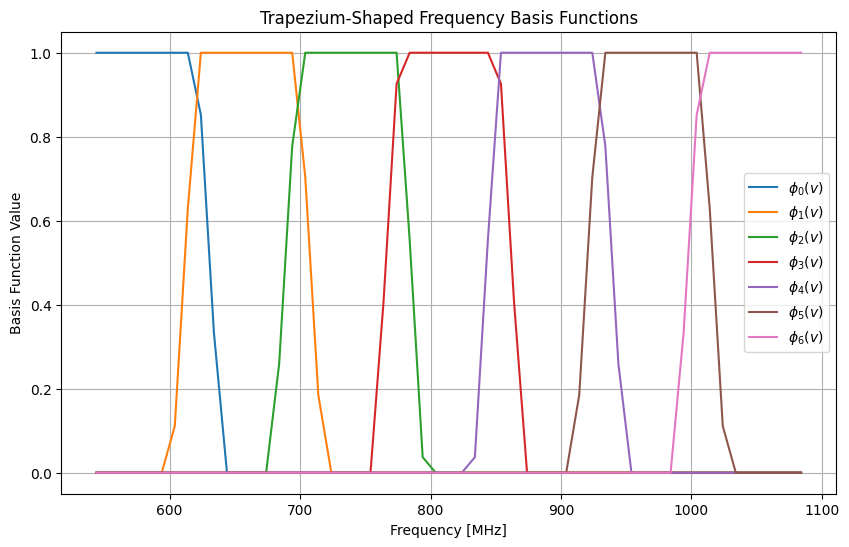

In [9]:
import matplotlib.pyplot as plt
phi= build_trapezoidal_basis(freqs, bins)
# Plot each basis function (each row of phi)
plt.figure(figsize=(10, 6))
for i in range(phi.shape[0]):
    plt.plot(freqs, phi[i], label=f"$\phi_{{{i}}}(v)$")

plt.xlabel("Frequency [MHz]")
plt.ylabel("Basis Function Value")
plt.title("Trapezium-Shaped Frequency Basis Functions")
plt.grid(True)
plt.legend()
plt.show()


Building the parametric HI model

In [10]:
from itertools import product
from numpy.linalg import lstsq

P, Q = 5,bins-1  #degree
v0=freqs[23]
n=0.5

# Step 1: Extract diagonal
nell, nf, _ = hi_d.shape
C_diag = np.array([np.diag(hi_d[i]) for i in range(nell)])  # shape (nell, nf)

# Step 2: Log coordinates
log_l = np.log10(leff)  # shape (nell,)
log_v = np.log10(freqs[:-1])  # shape (nf,)
scaling = (freqs[:-1] / v0)**(-n)  # shape (nf,)

# Step 3: Build hat-shaped basis
phi = build_trapezoidal_basis(freqs[:-1], bins)  # shape (nq, nf)
# Unnormalized Psi: each row is φ_q(v) * scaling
Psi_unnorm = phi * scaling[None, :]  # shape (nq, nf)

# Normalize across q (rows) for each v (column)
Psi = Psi_unnorm / Psi_unnorm.sum(axis=0, keepdims=True)
print(Psi.shape)# shape (nq, nf)
# Psi = phi * scaling[None, :]              # shape (nq, nf)

# Step 4: Build coeff matrix
basis_terms = list(product(range(P + 1), range(Q + 1))) # all (p, q) pairs (0,0), (0,1), ..., (P,Q)
n_terms = len(basis_terms) # total number of basis functions (P + 1) * (Q + 1)

X = np.zeros((nell * nf, n_terms))# rows = data points, cols = basis terms
y = C_diag.reshape(-1) #flatten target values to shape (nell * nf,)
print(y.shape)
print(len(leff)*nf)

for i, (p, q) in enumerate(basis_terms):
    # Outer product: (nell,) x (nf,) → shape (nell, nf)
    X[:, i] = np.outer(log_l**p, Psi[q,:]).reshape(-1)

# Step 5: Solve least mean squares
a_vec, residuals, rank, s = lstsq(X, y, rcond=None)
a_matrix = a_vec.reshape((P + 1, Q + 1))  # shape (P+1, Q+1)
print(a_matrix.shape)
print(a_vec.shape)

# Step 6: Reconstruct the fitted diagonal
C_fit_diag = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

# Step 7: Expand to full (nell, nf, nf) with diagonal only
C_fit = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_fit[i], C_fit_diag[i])


(7, 54)
(4104,)
4104
(6, 7)
(42,)


Least quares fitting by passing with the gradient of the model

In [85]:
from scipy.optimize import least_squares
# initial guess (e.g. from your lstsq solution)
a0 = np.zeros((P + 1) * (Q + 1))  # initial guess for coefficients

# residual vector r(a) = X a - y, and its Jacobian J(a) = X
def fun_res(a):
    return X.dot(a) - y
    # a_matrix = a.reshape((P + 1, Q + 1))
    # C_fit_diag = np.zeros((nell, nf))
    # for p in range(P + 1):
    #     for q in range(Q + 1):
    #         C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

    # # Step 7: Expand to full (nell, nf, nf) with diagonal only
    # C_fit = np.zeros((nell, nf, nf))
    # for i in range(nell):
    #     np.fill_diagonal(C_fit[i], C_fit_diag[i])
    # return C_fit.reshape(-1) - hi_d.reshape(-1)

def jac_res(a):
    # here X does *not* depend on a, so it's constant
    return X
    # n_coeffs=len(a)
    # a_matrix = a.reshape((P + 1, Q + 1))
    # dR= np.zeros((nbins, nfreqs,nfreqs, n_coeffs))
    # for b in range(nbins):
    #     for p in range(P + 1):
    #         for q in range(Q + 1):
    #             idx = q * (P + 1) + p
    #             dR[b, :,:, idx] = np.diag(((log_l[b] ** p) * Psi[q]))
    # return dR.reshape(-1, n_coeffs)

res = least_squares(fun_res, a0, jac=jac_res, method='lm')
a_opt = res.x.reshape((P+1, Q+1))

(6, 7)


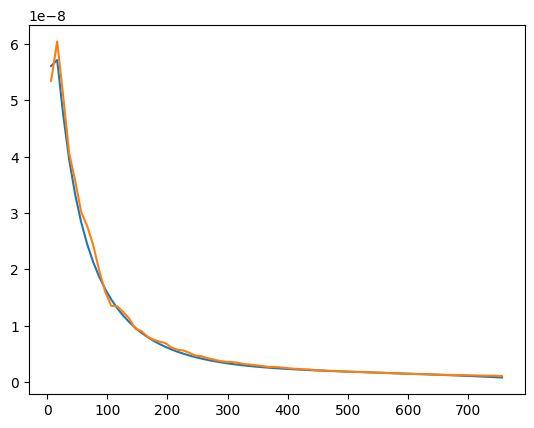

In [116]:
print(a_opt.shape)
C_ls_d = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_ls_d +=a_opt[p, q] * np.outer(log_l**p, Psi[q])

# Step 7: Expand to full (nell, nf, nf) with diagonal only
C_ls = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_ls[i], C_ls_d[i])
    
plt.plot(leff,C_ls[:,2,2])
plt.plot(leff,hi_d[:,2,2])
# plt.plot(leff,C_fit[:,2,2]- C_ls[:,2,2])

In [87]:
from pprint import pprint
pprint(res)

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-4.280e-08 -9.822e-09 ...  6.130e-12  1.093e-11]
           x: [-1.583e-07  9.439e-08 ... -5.413e-10 -3.216e-10]
        cost: 4.094663876029697e-15
         jac: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00 ...  0.000e+00  1.977e+02]
               [ 0.000e+00  0.000e+00 ...  0.000e+00  1.977e+02]]
        grad: [-1.271e-18 -1.634e-18 ... -9.802e-18 -2.460e-17]
  optimality: 2.38966410769596e-16
 active_mask: [0 0 ... 0 0]
        nfev: 2
        njev: 2


In [88]:
res.jac

array([[  1.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 197.72619443],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 197.72619443],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 197.72619443]], shape=(4104, 42))

Minimizing the loss with mean sq error by passing the gradient of the loss

In [101]:
from scipy.optimize import minimize

def loss(a):
    r = X.dot(a) - y
    # a_matrix = a.reshape((P + 1, Q + 1))
    # C_fit_diag = np.zeros((nell, nf))
    # for p in range(P + 1):
    #     for q in range(Q + 1):
    #         C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

    # # Step 7: Expand to full (nell, nf, nf) with diagonal only
    # C_fit = np.zeros((nell, nf, nf))
    # for i in range(nell):
    #     np.fill_diagonal(C_fit[i], C_fit_diag[i])
    # r = C_fit - hi_d
    return 0.5 * np.dot(r, r)

def grad_loss(a):
    r = X.dot(a) - y
    # ∇L = X^T r
    return X.T.dot(r)
    # n_coeffs=len(a)
    # a_matrix = a.reshape((P + 1, Q + 1))
    # C_fit_diag = np.zeros((nell, nf))
    # for p in range(P + 1):
    #     for q in range(Q + 1):
    #         C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

    # # Step 7: Expand to full (nell, nf, nf) with diagonal only
    # C_fit = np.zeros((nell, nf, nf))
    # for i in range(nell):
    #     np.fill_diagonal(C_fit[i], C_fit_diag[i])
    # r = C_fit - hi_d
    
    # dR= np.zeros((nbins, nfreqs,nfreqs, n_coeffs))
    # for b in range(nbins):
    #     for p in range(P + 1):
    #         for q in range(Q + 1):
    #             idx = q * (P + 1) + p
    #             dR[b, :,:, idx] = np.diag(((log_l[b] ** p) * Psi[q]))

    # return dR@r

res2 = minimize(loss, a_opt.flatten(),
                jac=grad_loss,
                method='L-BFGS-B',    # or 'CG', 'BFGS', …
                options={'disp': True})
a_opt2 = res2.x.reshape((P+1, Q+1))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           42     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09466D-15    |proj g|=  2.38966D-16

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   42      0      1      0     0     0   2.390D-16   4.095D-15
  F =   4.0946638760296972E-015

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [102]:
pprint(res2)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 4.094663876029697e-15
        x: [-1.583e-07  9.439e-08 ... -5.413e-10 -3.216e-10]
      nit: 0
      jac: [-1.271e-18 -1.634e-18 ... -9.802e-18 -2.460e-17]
     nfev: 1
     njev: 1
 hess_inv: <42x42 LbfgsInvHessProduct with dtype=float64>


In [103]:
res2.jac

array([-1.27103368e-18, -1.63419885e-18, -3.99084447e-19,  7.94147786e-19,
       -4.05640291e-19, -1.10621690e-19, -1.57538060e-19, -3.69758326e-18,
       -4.38693335e-18, -9.60423421e-19,  2.12897572e-18, -1.03668883e-18,
       -2.62277253e-19, -4.26075460e-19, -1.05713831e-17, -1.18059837e-17,
       -2.37174579e-18,  5.73001774e-18, -2.68597414e-18, -6.32680435e-19,
       -1.17750556e-18, -2.99868755e-17, -3.19401099e-17, -5.95996013e-18,
        1.54905805e-17, -7.04387054e-18, -1.55080211e-18, -3.26093912e-18,
       -8.47486573e-17, -8.67748197e-17, -1.51849342e-17,  4.21100337e-17,
       -1.86308789e-17, -3.86674174e-18, -8.88482306e-18, -2.38966411e-16,
       -2.36637788e-16, -3.91085340e-17,  1.14621552e-16, -4.96328592e-17,
       -9.80207648e-18, -2.45953172e-17])

(6, 7)


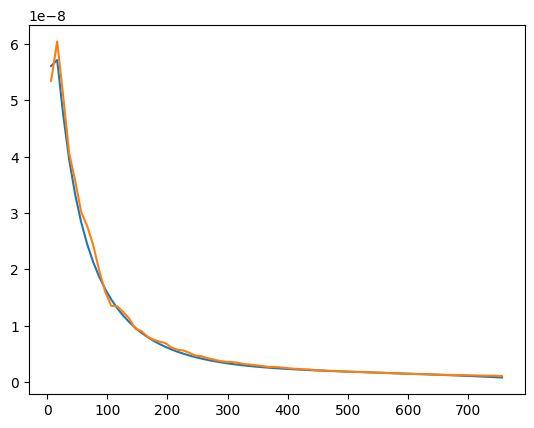

In [118]:
print(a_opt2.shape)
C_mse_d = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_mse_d +=a_opt2[p, q] * np.outer(log_l**p, Psi[q])

# Step 7: Expand to full (nell, nf, nf) with diagonal only
C_mse = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_mse[i], C_mse_d[i])

plt.plot(leff,C_mse[:,2,2])
plt.plot(leff,hi_d[:,2,2])
# plt.plot(leff,C_ls[:,2,2]- C_mse[:,2,2])

Using smica to minimize and passing gradient of the loss

In [144]:
from scipy.optimize import minimize
from numpy.linalg import slogdet, inv

# Parameters
# nell, nf, _ = hi_d.shape
# log_l = np.log10(leff)  # log of effective ells
# # a0 = np.zeros((P + 1, Q + 1)).reshape(-1)  # Initial guess: shape ((P+1)*(Q+1),)

# # Psi: trapezoidal basis scaled and normalized (from earlier)
# # shape (Q+1, nf)
# # Psi = ... (already defined earlier in your code)
# # Construct Psi (shape: (Q+1, nf))
# phi = build_trapezoidal_basis(freqs[:-1], bins)  # shape (Q+1, nf)
# scaling = (freqs[:-1] / v0)**(-n)                # shape (nf,)
# Psi_unnorm = phi * scaling[None, :]              # shape (Q+1, nf)
# Psi = Psi_unnorm / Psi_unnorm.sum(axis=0, keepdims=True)
# Step 1: Build C_ell from parameters
def build_C_model(logl,a_k):
    a_mat = a_k.reshape((P + 1, Q + 1))  # reshape flat a_vec to (P+1, Q+1)
    C_model = np.zeros((nell, nf, nf))
    for ell_idx in range(nell):
        Cl = np.zeros((nf, nf))
        for p in range(P + 1):
            loglp = logl[ell_idx]**p
            for q in range(Q + 1):
                a = a_mat[p, q]
                psi_q = Psi[q,:]  # shape (nf, 1)
                Cl += a * loglp * (psi_q @ psi_q.T)  # outer product
        C_model[ell_idx] = Cl
    return C_model  # shape (nell, nf, nf)

# Step 2: SMICA loss function
def smica_loss(a_k):
    C_model = build_C_model(log_l, a_k)
    loss = 0.0
    for ell in range(nell):
        C_emp = hi_d[ell]  # empirical HI covariance at that ell
        C_mod = C_model[ell]
        # Add small regularization to ensure invertibility
        C_mod += np.eye(nf) * 1e-6
        sign, logdet = slogdet(C_emp @ np.linalg.inv(C_mod))
        # if sign <= 0:
        #     return np.inf  # invalid logdet => reject this parameter set
        trace_term = np.trace(C_emp @ np.linalg.inv(C_mod))
        loss += trace_term - logdet
    return loss


# Step 3: Minimize the SMICA loss
res3 = minimize(smica_loss, x0=a_vec, method='trust-constr', options={ 'maxiter':3000, 'gtol':1e-3,'verbose': 2})
# res3 = minimize(smica_loss, a_vec,
#                 # jac=grad_loss,
#                 method='L-BFGS-B',    # or 'CG', 'BFGS', …
#                 options={'disp': True})
a_smica = res3.x.reshape((P + 1, Q + 1))


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  43   |   0   | +2.8807e+04 | 1.00e+00 | 2.36e+10 | 0.00e+00 |
|   2   |  86   |   1   | +2.8807e+04 | 5.00e-01 | 2.36e+10 | 0.00e+00 |
|   3   |  129  |   2   | +2.8807e+04 | 2.50e-01 | 2.36e+10 | 0.00e+00 |
|   4   |  172  |   3   | +2.8807e+04 | 1.25e-01 | 2.36e+10 | 0.00e+00 |
|   5   |  215  |   4   | +2.8807e+04 | 6.25e-02 | 2.36e+10 | 0.00e+00 |
|   6   |  258  |   5   | +2.8807e+04 | 3.12e-02 | 2.36e+10 | 0.00e+00 |
|   7   |  301  |   6   | +2.8807e+04 | 1.56e-02 | 2.36e+10 | 0.00e+00 |
|   8   |  344  |   7   | +2.8807e+04 | 7.81e-03 | 2.36e+10 | 0.00e+00 |
|   9   |  387  |   8   | +2.8807e+04 | 3.91e-03 | 2.36e+10 | 0.00e+00 |
|  10   |  430  |   9   | +2.8807e+04 | 1.95e-03 | 2.36e+10 | 0.00e+00 |
|  11   |  473  |  10   | +2.8807e+04 | 9.77e-04 | 2.36e+10 | 0.00e+00 |
|  12   |  516  |  11   | +2.8807e+04 | 4.88e-04 | 

(6, 7)


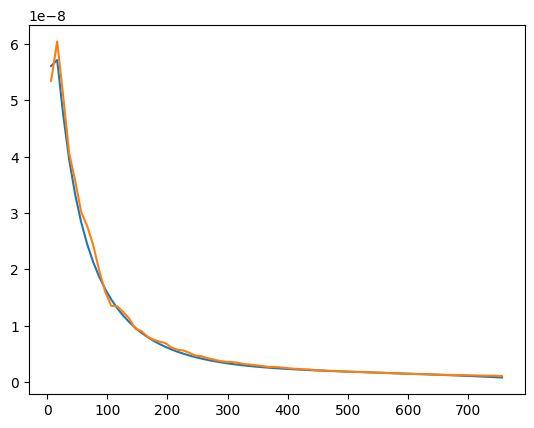

In [145]:
f=2
print(a_smica.shape)
C_smica_d = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_smica_d +=a_smica[p, q] * np.outer(log_l**p, Psi[q])

# Step 7: Expand to full (nell, nf, nf) with diagonal only
C_smica = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_smica[i], C_smica_d[i])
plt.plot(leff, C_smica[:,f,f])
# plt.plot(leff, C_mse[:,f,f])
plt.plot(leff, hi_d[:,f,f])

In [138]:
mode=build_C_model(log_l, a_vec)
def is_psd(func, tol=1e-20):
    eigenvalues = np.linalg.eigvalsh(func)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(mode))

Is model PSD? True


In [21]:
# Use LS-fitted coefficients
a_smica_test = a_opt2.flatten()
loss_val = smica_loss(a_smica_test)
print("SMICA loss with LS fit:", loss_val)


SMICA loss with LS fit: 28695.679577956947


In [47]:
def smica_cost(a_k, logl, trapezoid, R_data,poly):
    B, nf = R_data.shape[0], R_data.shape[1]
    Q1 = trapezoid.shape[0]
    n_coeffs = (poly + 1) * Q1
    phi = 0.0
    a_matrix = a_k.reshape((poly+1, Q1))
    

    for b in range(B):  # loop over ell bins
        logl_b = logl[b]         # scalar
        R_data_b = R_data[b]     # (nf, nf)

        # Construct HI diagonal: sum_p sum_q a_pq * (logl_b)^p * Psi_q
        C_HI_diag_b = np.zeros(nf)
        for p in range(poly + 1):
            for q in range(Q1):
                # idx = q * (poly + 1) + p
                C_HI_diag_b += a_matrix[p,q] * (logl_b ** p) * trapezoid[q,:]

        R_HI_b = np.diag(C_HI_diag_b)
        # print(C_HI_diag_b.shape)
        R_model_b = R_HI_b  # (nf, nf)
        R_model_inv_b = np.linalg.inv(R_model_b)   # (nf, nf)

        # Compute cost terms
        logdet_term = np.linalg.slogdet(R_data_b @ R_model_inv_b)[1]
        tr_term = np.trace(R_data_b @ R_model_inv_b)
        phi += (tr_term - logdet_term - nf) #n_b[b] * ((2*leff[b]+1)*10)*
    return phi
smica_cost(a_vec, log_l, Psi, hi_d, P)

np.float64(17.332176394579022)

In [ ]:
def jacobian(a_k, logl, trapezoid, R_data,poly):
    B, nf = R_data.shape[0], R_data.shape[1]
    Q1 = trapezoid.shape[0]
    n_coeffs = (poly + 1) * Q1
    a_matrix = a_k.reshape((poly+1, Q1))
    grad = np.zeros(n_coeffs)
    dR=np.zeros((B,nf, nf,n_coeffs))  # Initialize dR for each coefficient
    for b in range(B):
        logl_b = logl[b]         # scalar
    
        R_data_b = R_data[b]     # (nf, nf)

        # Construct HI diagonal: sum_p sum_q a_pq * (logl_b)^p * Psi_q
        C_HI_diag_b = np.zeros((nf,nf))
        for p in range(poly + 1):
            for q in range(Q1):
                idx = q * (poly + 1) + p
                C_HI_diag_b[:,:] += a_matrix[p,q] * (logl_b ** p) * trapezoid[q,:]* trapezoid[q,:].T  # outer product

        # R_HI_b = np.diag(C_HI_diag_b)
        # R_model_b = R_HI_b  # (nf, nf)
        R_model_inv_b = np.linalg.pinv(C_HI_diag_b)   # (nf, nf)
        # Compute gradient w.r.t. each coefficient
        for p in range(poly + 1):
            for q in range(Q1):
                idx = q * (poly + 1) + p
                dR[b,:,:,idx] = np.diag(((logl_b ** p) * trapezoid[q,:]* trapezoid[q,:].T))  # derivative of R_HI w.r.t a_pq #nfxnf
                # print(dR.shape)
                Delta=R_model_inv_b - R_model_inv_b @ R_data_b @ R_model_inv_b
                # dphi =- R_model_inv_b @ dR @ R_model_inv_b @ R_data_b + R_model_inv_b @ dR
                dphi= Delta @ dR[b,:,:,idx]  # derivative of R_HI w.r.t a_pq
                grad[idx] += np.trace(dphi) # n_b[b] *
    return grad
jacobian(a_vec, log_l, Psi, hi_d, P)

Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False
Is model PSD? False


array([4.25546602e+08, 1.14921405e+09, 3.12036223e+09, 8.50879557e+09,
       2.32851370e+10, 6.39171055e+10, 1.72602037e+08, 4.64822356e+08,
       1.25823121e+09, 3.42036028e+09, 9.33148361e+09, 2.55384658e+10,
       1.25039302e+08, 3.37321359e+08, 9.14484224e+08, 2.48941679e+09,
       6.80085506e+09, 1.86374577e+10, 8.56731507e+07, 2.31357264e+08,
       6.27690489e+08, 1.70973685e+09, 4.67319184e+09, 1.28122627e+10,
       6.50688062e+07, 1.75913974e+08, 4.77698900e+08, 1.30214162e+09,
       3.56130209e+09, 9.76889251e+09, 4.75916744e+07, 1.28845647e+08,
       3.50303013e+08, 9.55876824e+08, 2.61671138e+09, 7.18381731e+09,
       4.57733417e+07, 1.24031218e+08, 3.37442425e+08, 9.21269412e+08,
       2.52299743e+09, 6.92866232e+09])

In [112]:
# import numpy as np
# from scipy.optimize import minimize

# # Your basis functions are already defined:
# # Psi shape: (Q+1, nf)
# # log_l shape: (nell,)

# def model_diag_cov(a, log_l, Psi):
#     # a shape: (P+1, Q+1)
#     P, Q = a.shape[0]-1, a.shape[1]-1
#     nell, nf = log_l.shape[0], Psi.shape[1]
#     C_d = np.zeros((nell, nf))
#     for p in range(P + 1):
#         for q in range(Q + 1):
#             C_d += a[p, q] * np.outer(log_l**p, Psi[q])
#     # Ensure positivity (e.g. exponentiate if needed)
#     return C_d

# def smica_divergence(a_flat, log_l, Psi, hi_d):
#     a = a_flat.reshape((P+1, Q+1))
#     C_model_d = model_diag_cov(a, log_l, Psi)  # shape (nell, nf)
    
#     # Avoid zeros to prevent division errors
#     eps = 1e-12
#     C_model_d = np.clip(C_model_d, eps, None)
    
#     # hi_d: (nell, nf, nf), diagonal only
#     # Extract diagonal
#     hi_d_diag = np.array([np.diag(hi_d[i]) for i in range(nell)])  # shape (nell, nf)
    
#     term1 = np.sum(hi_d_diag / C_model_d)           # sum over all ell, freq
#     term2 = np.sum(np.log(hi_d_diag) - np.log(C_model_d))
#     n = hi_d.shape[1]  # nf
#     loss = term1 - term2 - n * nell
#     return loss

# # initial guess for a
# a0 = np.zeros((P+1)*(Q+1))

# res4 = minimize(smica_divergence, a0, args=(log_l, Psi, hi_d),
#                method='L-BFGS-B', 
#                options={'maxls':100,'disp': True})

# a_opt4= res4.x.reshape((P+1, Q+1))
